In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.getcwd().replace("notebooks","utils"))

import general_purpose as gp
from co2_functions import Classification as co2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,\
                    AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer,OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score,\
                            recall_score,roc_auc_score,classification_report
import warnings
import importlib

Módulo General Listo Para Usarse 💻
Hey!, el módulo co2 ha sido importado correctamente 🥳


In [2]:
df = gp.dataframes_charger("df_clusters_v1.csv")

In [60]:
df = df.drop(columns=["latitude","longitude","Year","CODE_x"])
df.head(3)

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,Country,Energy_type,continent,clusters,energy_type
0,279.389,15182.6,0.150,0.155,0.0,104.341,5.67,-0.005,0.0,0.001,0.0,0.0,Venezuela,renewables_n_other,South America,1,0
1,279.389,15182.6,5.000,0.812,0.0,104.341,5.67,4.188,0.0,0.003,0.0,0.0,Venezuela,petroleum_n_other_liquids,South America,3,3
2,279.389,15182.6,0.616,0.616,0.0,104.341,5.67,0.000,0.0,0.002,0.0,0.0,Venezuela,natural_gas,South America,3,2


In [61]:
lista_estimadores2 = [LogisticRegression(solver="newton-cg",max_iter=10000,C=0.0001),
AdaBoostClassifier(base_estimator=LogisticRegression(solver="newton-cg",max_iter=10000,C=0.0001)),
BaggingClassifier(base_estimator=LogisticRegression(solver="newton-cg",max_iter=10000,C=0.0001))]

Cuando usamos LogisticRegression la línea nunca converge debido a que es un problema multiclase y no le es posible encontrar una linea que divida a los cuatro grupos de manera correcta, aún cuando hemos incrementado el número de iteraciones hasta 10.000, usando los tres solver para multiclass de que dispone LogisticRegression. Aunque obtienen, buenos resultados, en las cuatro métricas, siempre están en el medio de la tabla y llenan el notebook de warnings que no hemos conseguido esconder y por tanto los ponemos a parte a efectos de comprobación de los resultados comentados.

In [62]:
lista_estimadores = [
    BernoulliNB(),ExtraTreeClassifier(),ExtraTreesClassifier(),
    KNeighborsClassifier(),SVC(),BaggingClassifier(base_estimator=SVC()),
    DecisionTreeClassifier(),
    RandomForestClassifier(),GradientBoostingClassifier(),GaussianNB()
]

In [63]:
y = df.clusters
x = df.drop(columns=["clusters","Energy_type","Country","continent"])
scv = ShuffleSplit(test_size=0.3,random_state=0)

In [64]:
# warnings.resetwarnings()
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
gp.crossval_models(x=x,y=y,folds=scv,estimadores=lista_estimadores,score="accuracy")

In [118]:
gp.crossval_models(x=x,y=y,folds=scv,estimadores=lista_estimadores,score="f1_micro")

In [119]:
gp.crossval_models(x=x,y=y,folds=scv,estimadores=lista_estimadores,score="precision_micro")

In [120]:
gp.crossval_models(x=x,y=y,folds=scv,estimadores=lista_estimadores,score="recall_micro")

Dado que en todas las métricas los tres mejores siempre son GradientBoostingClassifier, RandomForest y DecisionTreeClassifier serán los tres que vamos a tratar más en profundidad y uno de ellos será el elegido final. A priori, el que más nos gusta es DecisionTreeClassifier ya que, aunque es el tercero, de todos su dispersión entre las métricas de cada uno de los cross validation efectuados es la menor de todas, lo que nos indica que es un estimador robusto y fiable.  
Por otra parte, dada la experiencia en la selección de variables de RFECV, en esta ocasión solo vamos a usar esta opción para la selección de variables:

In [65]:
estimadores_elegidos = [DecisionTreeClassifier(),GradientBoostingClassifier(),RandomForestClassifier()]
gp.seleccion_variables(x,y,estimadores_elegidos,score="accuracy",n_cv=scv)

=======para el estimador DecisionTreeClassifier() los datos han sido=======
el número de variables seleccionadas ha sido: 2
el ranking de las variables vistas ha sido
 [12 10  1  8  1  6 11  2  4  7  9  3  5]
las variables elegidas han sido:
 ['Energy_production', 'CO2_emission']


=======para el estimador GradientBoostingClassifier() los datos han sido=======
el número de variables seleccionadas ha sido: 4
el ranking de las variables vistas ha sido
 [ 5  4  1  1  1  3  6  2  1  9 10  8  7]
las variables elegidas han sido:
 ['Energy_production', 'Energy_consumption', 'CO2_emission', 'eficiency']


=======para el estimador RandomForestClassifier() los datos han sido=======
el número de variables seleccionadas ha sido: 2
el ranking de las variables vistas ha sido
 [ 8  9  1  2  1 10 11  4  3  7 12  5  6]
las variables elegidas han sido:
 ['Energy_production', 'CO2_emission']


Las variables más elegidas han sido


,variables,veces
0,CO2_emission,3
2,Energy_production,3
1,Energy_consumption,1
3,eficiency,1


Vemos que a la hora de clasificar a nuestros países en un cluster han sido elegidas como las variables más importantes la emisión de co2 y la energía de producción. Estos resultados son coherentes con todo el estudio que se viene realizando, ya que son las variables más relacionadas con el objetivo que se persigue, que es en función de la producción considerar si los países emiten mucho o poco co2 y por tanto cuanto son de contaminantes. Además, las dos que más les importan son el consumo de energía, que tiene una relaciónd directa con la producción de energía y por tanto con el nivel de emisiones de co2 y la eficiencia que es resultado de todas las anteriores. Estas variables son además la base de la caracterización de los clusters de nuestro estudio.

In [66]:
vars_dt_rf = ['Energy_production', 'CO2_emission']
vars_xbc = ['Energy_production', 'Energy_consumption', 'CO2_emission', 'eficiency']
df2 = df.drop(columns=["Energy_type","Country","continent"])

## DECISION TREE CLASSIFIER

Miramos los datos a priori:

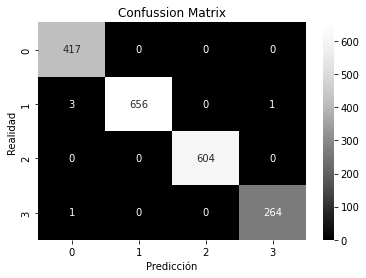

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       417
           1       1.00      0.99      1.00       660
           2       1.00      1.00      1.00       604
           3       1.00      1.00      1.00       265

    accuracy                           1.00      1946
   macro avg       1.00      1.00      1.00      1946
weighted avg       1.00      1.00      1.00      1946



In [8]:
x_train,x_test,y_train,y_test = gp.data_transform(df2,"clusters",PowerTransformer(),
                                test_size=0.3,
                                skip_x=[x for x in df2.columns if x not in vars_dt_rf])

dtc = DecisionTreeClassifier().fit(x_train,y_train)
pred = dtc.predict(x_test)

co2.new_classification_report(y_test,pred)

Vemos como generaliza nuestro modelo mediante cross-validation:

In [220]:
metricas = ["accuracy","precision_micro","recall_micro","f1_micro"]
gp.cross_validation_report(DecisionTreeClassifier(),x_train,y_train,scv,metricas)

----------(Cross Validation Metrics Report)----------
GLOBAL VIEW:
  - accuracy_medio: 0.995 (+/- 0.001 std)
  - precision_micro_medio: 0.995 (+/- 0.001 std)
  - recall_micro_medio: 0.995 (+/- 0.001 std)
  - f1_micro_medio: 0.995 (+/- 0.001 std)


# GRADIENT BOOSTING CLASSIFIER

Vemos como lo hace de manera individual con una sola particion del dataset:

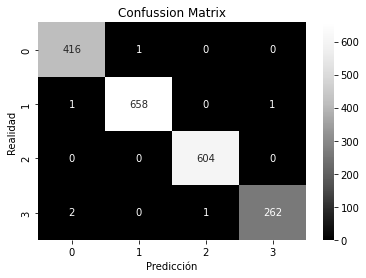

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       417
           1       1.00      1.00      1.00       660
           2       1.00      1.00      1.00       604
           3       1.00      0.99      0.99       265

    accuracy                           1.00      1946
   macro avg       1.00      1.00      1.00      1946
weighted avg       1.00      1.00      1.00      1946



In [48]:
x_train,x_test,y_train,y_test = gp.data_transform(df2,"clusters",PowerTransformer(),
                                test_size=0.3,
                                skip_x=[x for x in df2.columns if x not in vars_xbc])

dtc = GradientBoostingClassifier().fit(x_train,y_train)
pred = dtc.predict(x_test)

co2.new_classification_report(y_test,pred)

Vemos como lo haría con diferentes datos nuevos:

In [223]:
gp.cross_validation_report(GradientBoostingClassifier(),x_train,y_train,scv,metricas)

----------(Cross Validation Metrics Report)----------
GLOBAL VIEW:
  - accuracy_medio: 0.995 (+/- 0.001 std)
  - precision_micro_medio: 0.995 (+/- 0.001 std)
  - recall_micro_medio: 0.995 (+/- 0.002 std)
  - f1_micro_medio: 0.995 (+/- 0.001 std)


# RANDOM FORESTCLASSIFIER

Lo miramos de manera aislada:

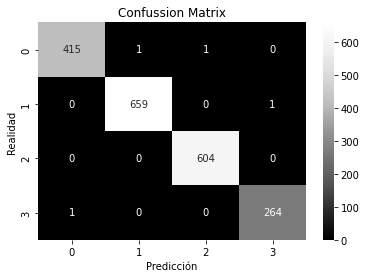

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       1.00      1.00      1.00       660
           2       1.00      1.00      1.00       604
           3       1.00      1.00      1.00       265

    accuracy                           1.00      1946
   macro avg       1.00      1.00      1.00      1946
weighted avg       1.00      1.00      1.00      1946



In [10]:
x_train,x_test,y_train,y_test = gp.data_transform(df2,"clusters",PowerTransformer(),
                                test_size=0.3,
                                skip_x=[x for x in df2.columns if x not in vars_dt_rf])

dtc = RandomForestClassifier().fit(x_train,y_train)
pred = dtc.predict(x_test)

co2.new_classification_report(y_test,pred)

Lo miramos de manera generalizada:

In [224]:
gp.cross_validation_report(RandomForestClassifier(),x_train,y_train,scv,metricas)

----------(Cross Validation Metrics Report)----------
GLOBAL VIEW:
  - accuracy_medio: 0.995 (+/- 0.002 std)
  - precision_micro_medio: 0.995 (+/- 0.002 std)
  - recall_micro_medio: 0.995 (+/- 0.002 std)
  - f1_micro_medio: 0.996 (+/- 0.002 std)


Parameter Tuning:

En este modelo no necesitaríamos hacer un hyperparameter tuning dado que los resultados son muy buenos, existiendo prácticamente una relación matematática entre las variables y el output. Esto es debido a que los clusters están hechos en base a las emisiones de co2 y la producción de energía y la eficiencia es la división entre las emisiones de co2 y la eficiencia. Por lo tanto, para llevar a cabo DecisionTree la clasificación, mediante estas dos variables, puede identificar correctamente a que cluster pertenecen. Debido a esto, lo que vamos ha hacer es que vamos a quitar las variables co2_emission,eficiency y Energy_production y vamos a ver como lo hace sin ellas.

In [75]:
using = ["Energy_production","eficiency","CO2_emission","Country","Energy_type"]

ohe = OneHotEncoder()
ohe.fit(df[["continent"]])
ohe_vals = ohe.transform(df[["continent"]])
ohe_df = pd.DataFrame(ohe_vals.toarray(),columns=ohe.get_feature_names_out())
df_pruebaclass = pd.merge(df.drop(columns=using),ohe_df,left_index=True,
                                    right_index=True).drop(columns="continent")
df_pruebaclass.head()

,GDP,Population,Energy_consumption,per_capita_production,Energy_intensity_by_GDP,balance,energy_dependecy,use_intensity_pc,co2_pc,clusters,energy_type,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America
0,279.389,15182.60,0.155,104.341,5.670,-0.005,0.001,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0
1,279.389,15182.60,0.812,104.341,5.670,4.188,0.003,0.0,0.0,3,3,0.0,0.0,0.0,0.0,0.0,1.0
2,279.389,15182.60,0.616,104.341,5.670,0.000,0.002,0.0,0.0,3,2,0.0,0.0,0.0,0.0,0.0,1.0
3,279.389,15182.60,0.002,104.341,5.670,-0.000,0.000,0.0,0.0,1,4,0.0,0.0,0.0,0.0,0.0,1.0
4,278.376,15597.88,0.161,110.257,6.178,-0.005,0.001,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0


In [77]:
pathwin = "C:/Users/ferna/OneDrive/Documentos/MIS_COSAS_DE_THE_BRIDGE/Proyectos_Machine_Learning/co2_ml/src/data/processed/"
pathmac = "/Users/fersaol/Library/CloudStorage/OneDrive-Personal/Documentos/MIS_COSAS_DE_THE_BRIDGE/Proyectos_Machine_Learning/co2_ml/src/data/processed/"
nombre = "df_pruebaclass_v1.csv"

df_pruebaclass.to_csv(pathmac + nombre,index=False,header=True)